# Quantum Cryptography: Quantum Key Distribution
***
### Contributors:
A.J. Rasmusson, Richard Barney

Have you ever wanted to send a super secret message to a friend? Then you need a key to encrypt your message, and your friend needs the same key to decrypt your message. But, how do you send a super secret key to your friend without your eavesdropping enemies finding out what it is? Businesses and governments face this problem every day. People are always innovating new ways to intercept personal data or other sensitive information. Ideally, we'd like to find a way to share information that cannot be intercepted. [Quantum key distribution](https://en.wikipedia.org/wiki/Quantum_key_distribution) (QKD) was created as a solution to this problem. In this tutorial, you'll learn about and implement a version of the [BB84 QKD protocol](https://en.wikipedia.org/wiki/BB84), developed by Bennet and Brassard, to generate a secure, [one-time pad](https://en.wikipedia.org/wiki/One-time_pad) encryption key.

Quantum key distribution is all about making the right information publicly known at the right times (and keeping the secret information secret). This tutorial will take you through a quantum key distribution between you (Alice) and your friend Bob. After you get a feel for the ropes by sending your first encrypted message to Bob, we'll introduce Eve--your eavesdropping enemy. You'll learn how to detect Eve's presence and thus prevent her from intercepting your super secret key and decrypting your messages.

In [1]:
#import all the packages

# Checking the version of PYTHON
import sys
if sys.version_info < (3,5):
    raise Exception('Please use Python version 3.5 or greater.')

#append to system path so qiskit and Qconfig can be found from home directory
sys.path.append('../qiskit-sdk-py/')

# Import the QuantumProgram and configuration
from qiskit import QuantumProgram
#import Qconfig

#other useful packages
import math

## Part 1: Encrypting and Decrypting a Message

### Pick Your Super Secret Message
The super secret message you want to send must be the same or less than the length of the super secret key.

If the key is shorter than the message, you will be forced to use parts of the key more than once. This may allow your lurking enemies to pick up a pattern in your encrypted message and possibly decrypt it. (As you'll see later on, we need to start out with a key at least double the number of characters used in your message. For now, don't worry about those details, pick your message! For this tutorial, we picked the initial key to be 3x greater--just to be safe.) Enter your message on the line below which reads "mes = ".

In [2]:
#Super secret message
mes = 'hello world'
print('Your super secret message: ',mes)

#initial size of key
n = len(mes)*3

#break up message into smaller parts if length > 10
nlist = []
for i in range(int(n/10)):
    nlist.append(10)
if n%10 != 0:
    nlist.append(n%10)

print('Initial key length: ',n)

Your super secret message:  hello world
Initial key length:  33


### The Big Picture
Now that you (Alice) have the key, here's the big question: how are we going to get your key to Bob without eavesdroppers intercepting it? Quantum key distribution! Here are the steps and big picture (the effects of eavesdropping will be discussed later on):
1. You (Alice) generate a random string--the key you wish to give to Bob.
2. You (Alice) convert your string bits into corresponding qubits.
3. You (Alice) send those qubits to Bob, BUT! you randomly rotate some into a superposition. This effectively turns your key into random noise. (This is good because your lurking enemies might measure your qubits.)
4. Bob receives yours qubits AND randomly rotates some qubits in the opposite direction before measuring.
5. Alice and Bob publicly share which qubits they rotated. When they both did the same thing (either both did nothing or both rotated), they know the original key bit value made it to Bob! (Overall, you can see that only some of the bits from Alice's original key should make it.)
6. Alice and Bob create their keys. Alice modifies her original key by keeping only the bits that she knows made it to Bob. Bob does the same.

Alice and Bob now have matching keys! They can now use this key to encrypt and decrypt their messages.

<img src='QKDnoEve.png'>
Here we see Alice sending the initial key to Bob. She sends her qubits and rotates them based on her rotation string. Bob rotates the incoming qubits based on his rotation string and measures the qubits.

### Step 1: Alice Generates a Random Key
You and your friend need a super secret key so you can encrypt your message and your friend can decrypt it. Let's make a key--a pure random key.

To make a purely random string, we'll use quantum superposition. A qubit in the xy-plane of the [Bloch sphere](https://quantumexperience.ng.bluemix.net/qx/tutorial?sectionId=beginners-guide&page=004-The_Weird_and_Wonderful_World_of_the_Qubit~2F001-The_Weird_and_Wonderful_World_of_the_Qubit) is in a 50-50 [superposition](https://quantumexperience.ng.bluemix.net/qx/tutorial?sectionId=beginners-guide&page=005-Single-Qubit_Gates~2F002-Creating_superposition); 50% of the time it'll be measured as 0, and 50% of the time it'll be measured as 1. We have Alice prepare several qubits like this and measure them to generate a purely random string of 1s and 0s.

In [3]:
# Make random strings of length string_length

def randomStringGen(string_length):
    #output variables used to access quantum computer results at the end of the function
    output_list = []
    output = ''
    
    #start up your quantum program
    qp = QuantumProgram()
    backend = 'local_qasm_simulator'  
    circuits = ['rs']
    
    #run circuit in batches of 10 qubits for fastest results. The results
    #from each run will be appended and then clipped down to the right n size.
    n = string_length
    temp_n = 10
    temp_output = ''
    for i in range(math.ceil(n/temp_n)):
        #initialize quantum registers for circuit
        q = qp.create_quantum_register('q',temp_n)
        c = qp.create_classical_register('c',temp_n)
        rs = qp.create_circuit('rs',[q],[c])
            
        #create temp_n number of qubits all in superpositions
        for i in range(temp_n):
            rs.h(q[i]) #the .h gate is the Hadamard gate that makes superpositions
            rs.measure(q[i],c[i])

        #execute circuit and extract 0s and 1s from key
        result = qp.execute(circuits, backend, shots=1)
        counts = result.get_counts('rs')
        result_key = list(result.get_counts('rs').keys())
        temp_output = result_key[0]
        output += temp_output
        
    #return output clipped to size of desired string length
    return output[:n]

In [4]:
key = randomStringGen(n)
print('Initial key: ',key)

Initial key:  111111000111011000011100011001111


### Steps 2-4: Send Alice's Qubits to Bob
Alice turns her key bits into corresponding qubit states. If a bit is a 0 she will prepare a qubit on the negative z axis. If the bit is a 1 she will prepare a qubit on the positive z axis. Next, if Alice has a 1 in her rotate string, she rotates her key qubit with a [Hadamard](https://quantumexperience.ng.bluemix.net/qx/tutorial?sectionId=beginners-guide&page=005-Single-Qubit_Gates~2F002-Creating_superposition) gate. She then sends the qubit to Bob. If Bob has a 1 in his rotate string, he rotates the incoming qubit in the opposite direction with a Hadamard gate. Bob then measures the state of the qubit and records the result. The quantum circuit below executes each of these steps.

In [5]:
#generate random rotation strings for Alice and Bob
Alice_rotate = randomStringGen(n)
Bob_rotate = randomStringGen(n)
print("Alice's rotation string:",Alice_rotate)
print("Bob's rotation string:  ",Bob_rotate)

#start up your quantum program
backend = 'local_qasm_simulator'  
shots = 1
circuits = ['send_over']
Bob_result = ''

for ind,l in enumerate(nlist):
    #define temp variables used in breaking up quantum program if message length > 10
    if l < 10:
        key_temp = key[10*ind:10*ind+l]
        Ar_temp = Alice_rotate[10*ind:10*ind+l]
        Br_temp = Bob_rotate[10*ind:10*ind+l]
    else:
        key_temp = key[l*ind:l*(ind+1)]
        Ar_temp = Alice_rotate[l*ind:l*(ind+1)]
        Br_temp = Bob_rotate[l*ind:l*(ind+1)]
    
    #start up the rest of your quantum program
    qp2 = QuantumProgram()
    q = qp2.create_quantum_register('q',l)
    c = qp2.create_classical_register('c',l)
    send_over = qp2.create_circuit('send_over',[q],[c])
    
    #prepare qubits based on key; add Hadamard gates based on Alice's and Bob's
    #rotation strings
    for i,j,k,n in zip(key_temp,Ar_temp,Br_temp,range(0,len(key_temp))):
        i = int(i)
        j = int(j)
        k = int(k)
        if i > 0:
            send_over.x(q[n])
        #Look at Alice's rotation string
        if j > 0:
            send_over.h(q[n])
        #Look at Bob's rotation string
        if k > 0:
            send_over.h(q[n])
        send_over.measure(q[n],c[n])

    #execute quantum circuit
    result_so = qp2.execute(circuits, backend, shots=shots)
    counts_so = result_so.get_counts('send_over')
    result_key_so = list(result_so.get_counts('send_over').keys())
    Bob_result += result_key_so[0][::-1]
    
print("Bob's results: ", Bob_result)

Alice's rotation string: 110110100010110010011100011000010
Bob's rotation string:   010101100000101010010101111010111
Bob's results:  011100000101011000010101011011010


### Steps 5-6: Compare Rotation Strings and Make Keys
Alice and Bob can now generate a secret quantum encryption key. First, they publicly share their rotation strings. If a bit in Alice's rotation string is the same as the corresponding bit in Bob's they know that Bob's result is the same as what Alice sent. They keep these bits to form the new key. (Alice based on her original key and Bob based on his measured results).

In [6]:
def makeKey(rotation1,rotation2,results):
    key = ''
    count = 0
    for i,j in zip(rotation1,rotation2):
        if i == j:
            key += results[count]
        count += 1
    return key
  
Akey = makeKey(Bob_rotate,Alice_rotate,key)
Bkey = makeKey(Bob_rotate,Alice_rotate,Bob_result)

print("Alice's key:",Akey)
print("Bob's key:  ",Bkey)

Alice's key: 111000110000011011011
Bob's key:   111000110000011011011


### Pause
We see that using only the public knowledge of Bob's and Alice's rotation strings, Alice and Bob can create the same identical key based on Alice's initial random key and Bob's results. Wow!! :D

<strong>If Alice's and Bob's key length is less than the message</strong>, the encryption is compromised. If this is the case for you, rerun all the cells above and see if you get a longer key. (We set the initial key length to 3x the message length to avoid this, but it's still possible.)

### Encrypt (and decrypt) using quantum key
We can now use our super secret key to encrypt and decrypt messages!! (of length less than the key). Note: the below "encryption" method is not powerful and should not be used for anything you want secure; it's just for fun. In real life, the super secret key you made and shared with Bob would be used in a much more sophisticated encryption algorithm.

In [7]:
#make key same length has message
shortened_Akey = Akey[:len(mes)]
encoded_m=''

#encrypt message mes using encryption key final_key
for m,k in zip(mes,shortened_Akey):
    encoded_c = chr(ord(m) + 2*ord(k) % 256)
    encoded_m += encoded_c
print('encoded message:  ',encoded_m)

#make key same length has message
shortened_Bkey = Bkey[:len(mes)]

#decrypt message mes using encryption key final_key
result = ''
for m,k in zip(encoded_m,shortened_Bkey):
    encoded_c = chr(ord(m) - 2*ord(k) % 256)
    result += encoded_c
print('recovered message:',result)

encoded message:   ÊÇÎÌÏÙÑÒÌÄ
recovered message: hello world


# Part 2: Eve the Eavesdropper
What if someone  is eavesdropping on Alice and Bob's line of communication? This process of random string making and rotations using quantum mechanics is only useful if it's robust against eavesdroppers.

Eve is your lurking enemy. She eavesdrops by intercepting your transmission to Bob. To be sneaky, Eve must send on the intercepted transmission--otherwise Bob will never receive anything and know that something is wrong!

Let's explain further why Eve can be detected. If Eve intercepts a qubit from Alice, she will not know if Alice rotated its state or not. Eve can only measure a 0 or 1. And she can't measure the qubit and then send the same qubit on, because her measurement will destroy the quantum state. Consequently, Eve doesn't know when or when not to rotate to recreate Alice's original qubit. She may as well send on qubits that have not been rotated, hoping to get the rotation right 50% of the time. After she sends these qubits to Bob, Alice and Bob can compare select parts of their keys to see if they have discrepancies in places they should not.

The scheme goes as follows:
1. Alice sends her qubit transmission Bob--but Eve measures the results
2. To avoid suspicion, Eve prepares qubits corresponding to the bits she measured and sends them to Bob.
3. Bob and Alice make their keys like normal
4. Alice and Bob randomly select the same parts of their keys to share publicly
5. If the selected part of the keys don't match, they know Eve was eavesdropping
6. If the selected part of the keys DO match, they can be confident Eve wasn't eavesdropping
7. They throw away the part of the key they made public and encrypt and decrypt super secret messages with the portion of the key they have left.

<img src="QKD.png">
Here we see Alice sending her qubits, rotationing them based on her rotation string, and Eve intercepting the transmittion. Eve then sending her results onto Bob who--like normal--rotates and measures the qubits.

### Step 1: Eve intercepts Alice's transmission

The code below has Alice sending her qubits and Eve intercepting them. It then displays the results of Eve's measurements.

In [8]:
#start up your quantum program
backend = 'local_qasm_simulator'  
shots = 1
circuits = ['Eve']

Eve_result = ''
for ind,l in enumerate(nlist):
    #define temp variables used in breaking up quantum program if message length > 10
    if l < 10:
        key_temp = key[10*ind:10*ind+l]
        Ar_temp = Alice_rotate[10*ind:10*ind+l]
    else:
        key_temp = key[l*ind:l*(ind+1)]
        Ar_temp = Alice_rotate[l*ind:l*(ind+1)]
    
    #start up the rest of your quantum program
    qp3 = QuantumProgram()
    q = qp3.create_quantum_register('q',l)
    c = qp3.create_classical_register('c',l)
    Eve = qp3.create_circuit('Eve',[q],[c])
    
    #prepare qubits based on key; add Hadamard gates based on Alice's and Bob's
    #rotation strings
    for i,j,n in zip(key_temp,Ar_temp,range(0,len(key_temp))):
        i = int(i)
        j = int(j)
        if i > 0:
            Eve.x(q[n])
        if j > 0:
            Eve.h(q[n])
        Eve.measure(q[n],c[n])
    
    #execute
    result_eve = qp3.execute(circuits, backend, shots=shots)
    counts_eve = result_eve.get_counts('Eve')
    result_key_eve = list(result_eve.get_counts('Eve').keys())
    Eve_result += result_key_eve[0][::-1]

print("Eve's results: ", Eve_result)

Eve's results:  001111000111011000000100010001101


### Step 2: Eve deceives Bob
Eve sends her measured qubits on to Bob to deceive him! Since she doesn't know which of the qubits she measured were in a superposition or not, she doesn't even know whether to send the exact values she measured or opposite values. In the end, sending on the exact values is just as good a deception as mixing them up again.

In [9]:
#start up your quantum program
backend = 'local_qasm_simulator'  
shots = 1
circuits = ['Eve2']

Bob_badresult = ''
for ind,l in enumerate(nlist):
    #define temp variables used in breaking up quantum program if message length > 10
    if l < 10:
        key_temp = key[10*ind:10*ind+l]
        Eve_temp = Eve_result[10*ind:10*ind+l]
        Br_temp = Bob_rotate[10*ind:10*ind+l]
    else:
        key_temp = key[l*ind:l*(ind+1)]
        Eve_temp = Eve_result[l*ind:l*(ind+1)]
        Br_temp = Bob_rotate[l*ind:l*(ind+1)]
    
    #start up the rest of your quantum program
    qp4 = QuantumProgram()
    q = qp4.create_quantum_register('q',l)
    c = qp4.create_classical_register('c',l)
    Eve2 = qp4.create_circuit('Eve2',[q],[c])
    
    #prepare qubits
    for i,j,n in zip(Eve_temp,Br_temp,range(0,len(key_temp))):
        i = int(i)
        j = int(j)
        if i > 0:
            Eve2.x(q[n])
        if j > 0:
            Eve2.h(q[n])
        Eve2.measure(q[n],c[n])
    
    #execute
    result_eve = qp4.execute(circuits, backend, shots=shots)
    counts_eve = result_eve.get_counts('Eve2')
    result_key_eve = list(result_eve.get_counts('Eve2').keys())
    Bob_badresult += result_key_eve[0][::-1]
    
print("Bob's previous results (w/o Eve):",Bob_result)
print("Bob's results from Eve:\t\t ",Bob_badresult)

Bob's previous results (w/o Eve): 011100000101011000010101011011010
Bob's results from Eve:		  001011000111010000010000110001000


### Step 4: Spot Check
Alice and Bob know Eve is lurking out there. They decide to pick a few random values from their individual keys and compare with each other. This requires making these subsections of their keys public (so the other can see them). If any of the values in their keys are different, they know Eve's eavesdropping messed up the superposition Alice originally created! If they find all the values are identical, they can be reasonably confident that Eve wasn't eavesdropping. Of course, making some random key values known to the public will require them to remove those values from their keys because those parts are no longer super secret. Also, Alice and Bob need to make sure they are sharing corresponding values from their respective keys.

Let's make a check key. If the randomly generated check key is a one, Alice and Bob will compare that part of their keys with each other (aka make publicly known).

In [10]:
#make keys for Alice and Bob
Akey = makeKey(Bob_rotate,Alice_rotate,key)
Bkey = makeKey(Bob_rotate,Alice_rotate,Bob_badresult)
print("Alice's key:   ",Akey)
print("Bob's key:     ",Bkey)

check_key = randomStringGen(len(Akey))
print('spots to check:',check_key)

Alice's key:    111000110000011011011
Bob's key:      010000110000010010010
spots to check: 110011110011111101101


### Steps 5-7: Compare strings and detect Eve
Alice and Bob compare the subsections of their keys. If they notice any discrepancy, they know that Eve was trying to intercept their message. They create new keys by throwing away the parts they shared publicly. It's possible that by throwing these parts away, they will not have a key long enough to encrypt the message and they will have to try again.

In [11]:
#find which values in rotation string were used to make the key
Alice_keyrotate = makeKey(Bob_rotate,Alice_rotate,Alice_rotate)
Bob_keyrotate = makeKey(Bob_rotate,Alice_rotate,Bob_rotate)

# Detect Eve's interference
#extract a subset of Alice's key
sub_Akey = ''
sub_Arotate = ''
count = 0
for i,j in zip(Alice_rotate,Akey):
    if int(check_key[count]) == 1:
        sub_Akey += Akey[count]
        sub_Arotate += Alice_keyrotate[count]
    count += 1

#extract a subset of Bob's key
sub_Bkey = ''
sub_Brotate = ''
count = 0
for i,j in zip(Bob_rotate,Bkey):
    if int(check_key[count]) == 1:
        sub_Bkey += Bkey[count]
        sub_Brotate += Bob_keyrotate[count]
    count += 1
print("subset of Alice's key:",sub_Akey)
print("subset of Bob's key:  ",sub_Bkey)

#compare Alice and Bob's key subsets
secure = True
for i,j in zip(sub_Akey,sub_Bkey):
    if i == j:
        secure = True
    else:
        secure = False
        break;
if not secure:
    print('Eve detected!')
else:
    print('Eve escaped detection!')

#sub_Akey and sub_Bkey are public knowledge now, so we remove them from Akey and Bkey
if secure:
    new_Akey = ''
    new_Bkey = ''
    for index,i in enumerate(check_key):
        if int(i) == 0:
            new_Akey += Akey[index]
            new_Bkey += Bkey[index]
    print('new A and B keys: ',new_Akey,new_Bkey)
    if(len(mes)>len(new_Akey)):
        print('Your new key is not long enough.')

subset of Alice's key: 110011000110101
subset of Bob's key:   010011000100000
Eve detected!


# Probability of Detecting Eve
The longer the key, the more likely you will detect Eve. In fact, the [probability](hhttps://en.wikipedia.org/wiki/Quantum_key_distribution#Intercept_and_resend) goes up as a function of $1 - (3/4)^n$ where n is the number of bits Alice and Bob compare in their spot check. So, the longer the key, the more bits you can use to compare and the more likely you will detect Eve.

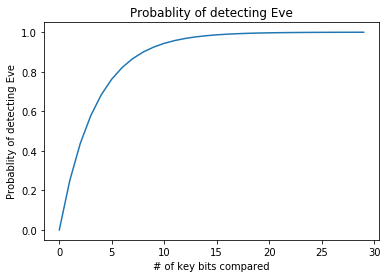

In [13]:
#!!! you may need to execute this cell twice in order to see the output due to an problem with matplotlib

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0., 30.0)
y = 1-(3/4)**x
plt.plot(y)
plt.title('Probablity of detecting Eve')
plt.xlabel('# of key bits compared')
plt.ylabel('Probablity of detecting Eve')
plt.show()